# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.48KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

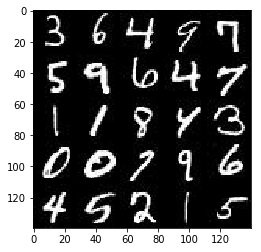

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [34]:
mnist_images.mean()

106.94918

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

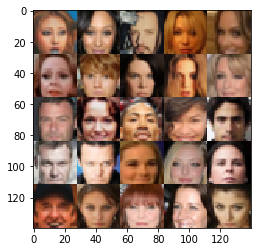

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # layer 1, 14x14x64, batch nomalization alpha=0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.2*x1, x1)
        # layer2, 7x7x128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2*x2, x2)
        # out
        logits = tf.layers.dense(tf.reshape(x2, (-1, 7*7*128)), 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        # batch normalization
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2*x1, x1)
        # layer2, 14x14x256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2*x2, x2)
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [65]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # scale image to [-1,1]
                batch_images = batch_images*2
                # Sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

                

In [64]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
batch1 = mnist_dataset.get_batches(1)
img1 = next(batch1)
img1.min(),img1.max()

(-0.5, 0.5)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4327... Generator Loss: 1.2728
Epoch 1/2... Discriminator Loss: 0.3138... Generator Loss: 1.9459
Epoch 1/2... Discriminator Loss: 0.1102... Generator Loss: 3.1599
Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 0.6830
Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 1.1242
Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.4933
Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.9429
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.6236
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.9285


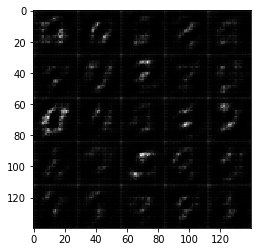

Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.9884
Epoch 1/2... Discriminator Loss: 1.6794... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 0.5313
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 0.7808
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 0.6660
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 0.8173


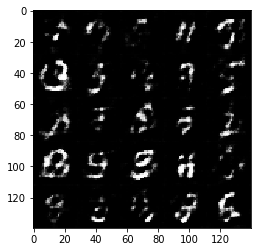

Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 0.6660
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.6636
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.5337
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 0.8703
Epoch 1/2... Discriminator Loss: 1.0526... Generator Loss: 1.3219
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 1.1555... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 0.8924... Generator Loss: 1.0386
Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.1071... Generator Loss: 0.9427


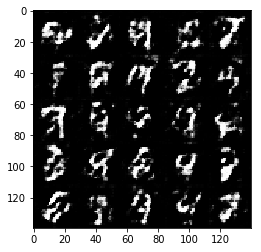

Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 1.0320
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.5554
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 1.6388
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.4244
Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 0.4643
Epoch 1/2... Discriminator Loss: 0.9567... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 0.4989


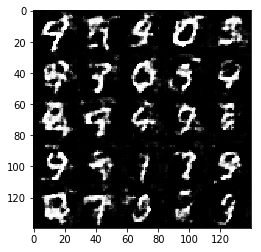

Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.4392
Epoch 1/2... Discriminator Loss: 0.9325... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.6241
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 1.8581
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 0.6122
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 0.9533
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 0.3846
Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 1.3952
Epoch 1/2... Discriminator Loss: 1.0974... Generator Loss: 1.7644


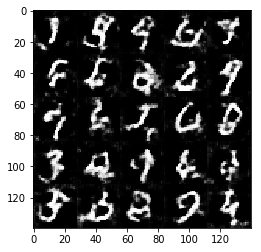

Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.3955
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 1.6371... Generator Loss: 0.3346
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 0.5129
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 0.5525
Epoch 1/2... Discriminator Loss: 1.8249... Generator Loss: 0.2162
Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 1.1419
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 0.5174


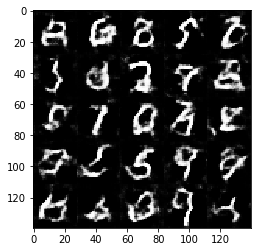

Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 1.3735
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.5929
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.6799
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.6035
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 1.2152
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.4236
Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 1.3450
Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 1.2878


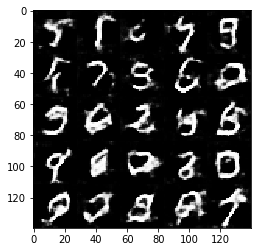

Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.8412
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.3098... Generator Loss: 1.5433
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 1.6750
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.7534
Epoch 1/2... Discriminator Loss: 1.0638... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.3958
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 0.8310


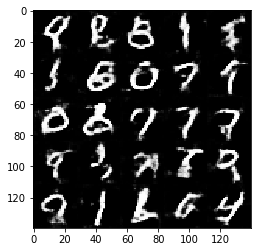

Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 1.3112
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 1.1264
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.6091
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 1.0511
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 1.0125
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 0.9599
Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 1.0111
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 0.5765


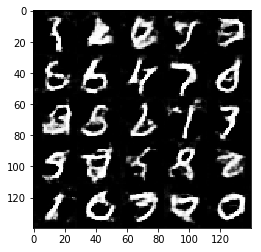

Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.6214
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 1.1886
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 1.1125
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.5355
Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.1160... Generator Loss: 0.6498
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 0.7376
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 1.2054


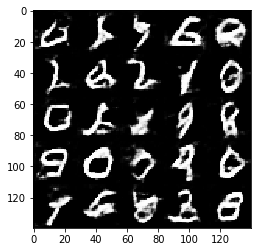

Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 0.9649
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 1.3304... Generator Loss: 0.4434
Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.5483
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 1.1328
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 0.8201
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 1.4569
Epoch 1/2... Discriminator Loss: 1.4066... Generator Loss: 0.4421


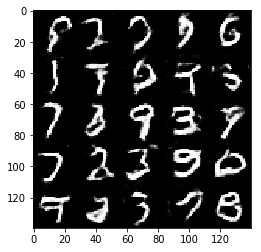

Epoch 1/2... Discriminator Loss: 1.4855... Generator Loss: 1.3414
Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 0.8956
Epoch 1/2... Discriminator Loss: 1.5893... Generator Loss: 0.3121
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 0.5706
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 0.5287
Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 1.4412
Epoch 1/2... Discriminator Loss: 1.9601... Generator Loss: 0.1944
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 1.3747
Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 0.5553


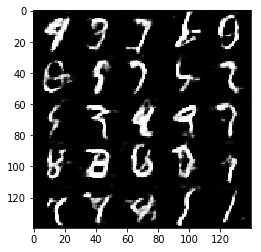

Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.5855
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.5524
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 0.9271
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.6022
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 0.5895
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 0.7466


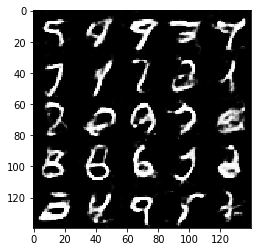

Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 0.5145
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 1.5303
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 1.1149
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 0.7083
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 0.6083
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.4456
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 1.1189


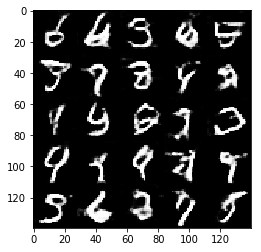

Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.9557
Epoch 1/2... Discriminator Loss: 2.1512... Generator Loss: 0.1685
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 1.4131
Epoch 1/2... Discriminator Loss: 0.9457... Generator Loss: 1.4017
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 0.5794
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 0.9121
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 1.4014


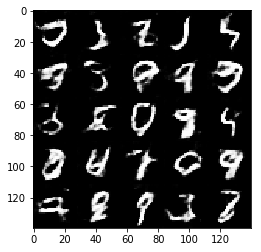

Epoch 1/2... Discriminator Loss: 1.0372... Generator Loss: 0.7754
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 0.5350
Epoch 1/2... Discriminator Loss: 1.1053... Generator Loss: 0.6025
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 1.5676
Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 1.0509
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 0.9025
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.0078
Epoch 1/2... Discriminator Loss: 1.1631... Generator Loss: 0.5534
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 0.9397


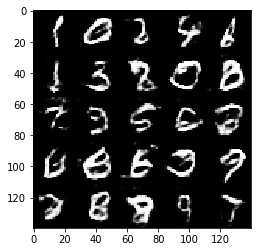

Epoch 1/2... Discriminator Loss: 1.1555... Generator Loss: 0.6822
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.6050
Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 1.1818
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 0.9082... Generator Loss: 0.9034
Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 0.8996
Epoch 1/2... Discriminator Loss: 1.7604... Generator Loss: 2.9579
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 1.1931
Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.6413


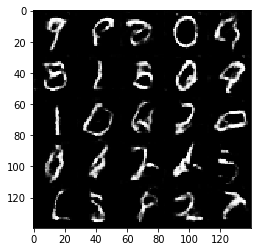

Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 0.5189
Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 1.7224
Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 0.4607
Epoch 1/2... Discriminator Loss: 0.8484... Generator Loss: 1.0269
Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 0.8792
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 1.6585
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.4087
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.4324
Epoch 1/2... Discriminator Loss: 0.9006... Generator Loss: 0.7540


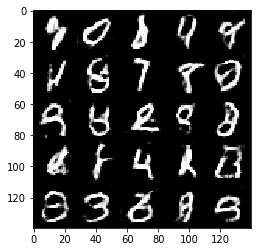

Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 0.9209
Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 1.2716
Epoch 1/2... Discriminator Loss: 1.6887... Generator Loss: 0.3062
Epoch 1/2... Discriminator Loss: 0.8150... Generator Loss: 1.3277
Epoch 1/2... Discriminator Loss: 0.8660... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 1.7932
Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.1147
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.4273
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 0.6429
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 0.6355


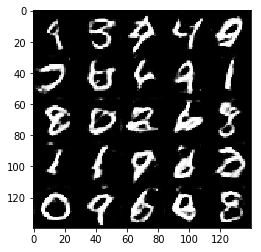

Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 0.5510
Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 0.9060
Epoch 2/2... Discriminator Loss: 0.5611... Generator Loss: 1.3175
Epoch 2/2... Discriminator Loss: 1.5841... Generator Loss: 2.6314
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 0.6104
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 1.0691
Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 1.7203
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 1.1479
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 1.6944
Epoch 2/2... Discriminator Loss: 0.8198... Generator Loss: 1.5949


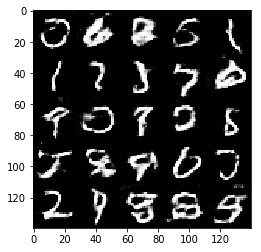

Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 1.3090
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.3805
Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 1.3759
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.4660
Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.1096
Epoch 2/2... Discriminator Loss: 1.7413... Generator Loss: 0.3059
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 0.6127


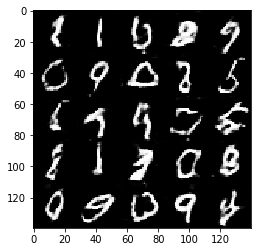

Epoch 2/2... Discriminator Loss: 0.9354... Generator Loss: 0.7865
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.1892
Epoch 2/2... Discriminator Loss: 1.0441... Generator Loss: 1.8838
Epoch 2/2... Discriminator Loss: 1.1988... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.6753
Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.3849
Epoch 2/2... Discriminator Loss: 1.8183... Generator Loss: 2.2136
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 1.2259
Epoch 2/2... Discriminator Loss: 0.7498... Generator Loss: 1.5539


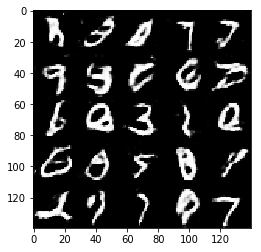

Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 0.9517
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 1.0556... Generator Loss: 1.7480
Epoch 2/2... Discriminator Loss: 0.8759... Generator Loss: 1.1042
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 0.6394
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.2449
Epoch 2/2... Discriminator Loss: 0.9679... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 0.9994
Epoch 2/2... Discriminator Loss: 1.0300... Generator Loss: 0.6368
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 2.5647


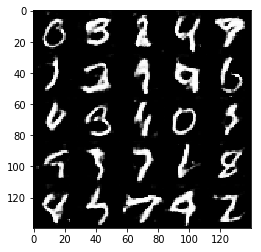

Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.0051
Epoch 2/2... Discriminator Loss: 0.9430... Generator Loss: 0.7721
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 0.6832
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 0.9292
Epoch 2/2... Discriminator Loss: 1.8945... Generator Loss: 0.2568
Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 1.1905... Generator Loss: 0.4643


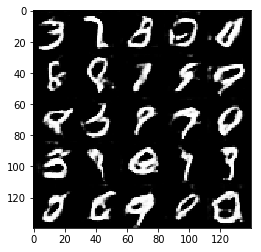

Epoch 2/2... Discriminator Loss: 1.0214... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 0.6976... Generator Loss: 1.3711
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.4536
Epoch 2/2... Discriminator Loss: 1.8155... Generator Loss: 0.2750
Epoch 2/2... Discriminator Loss: 1.2458... Generator Loss: 0.6048
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 0.9814
Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 0.8593
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 1.1345


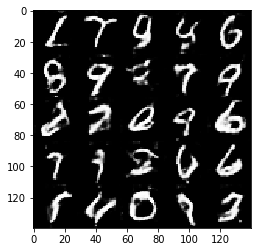

Epoch 2/2... Discriminator Loss: 0.7758... Generator Loss: 1.1980
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.5062
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 0.7388... Generator Loss: 1.4947
Epoch 2/2... Discriminator Loss: 1.0341... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.4512
Epoch 2/2... Discriminator Loss: 1.0310... Generator Loss: 0.6320
Epoch 2/2... Discriminator Loss: 0.6020... Generator Loss: 1.5236
Epoch 2/2... Discriminator Loss: 1.5724... Generator Loss: 0.2885
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 0.7609


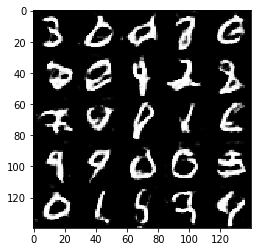

Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 2.2113
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 1.1681
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 0.4386
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 1.4386
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.4640
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 0.5844
Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 1.3986
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 0.9467
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 0.8264
Epoch 2/2... Discriminator Loss: 0.8980... Generator Loss: 0.8311


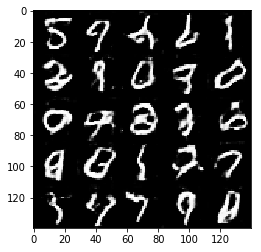

Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 0.7066
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 0.9341... Generator Loss: 0.7596
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 2.2615
Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 0.8704
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.4007
Epoch 2/2... Discriminator Loss: 1.0208... Generator Loss: 0.7040
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.2934
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 1.1927
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 1.8290


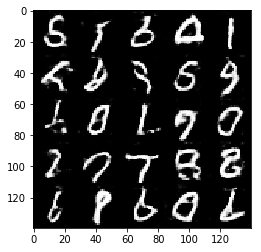

Epoch 2/2... Discriminator Loss: 1.9478... Generator Loss: 0.2032
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 1.5654
Epoch 2/2... Discriminator Loss: 0.8594... Generator Loss: 1.2760
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 0.5072
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 2.8548
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 0.5384
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 0.9633


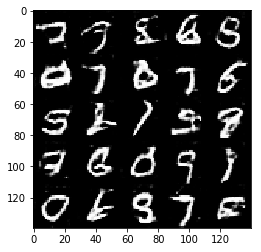

Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 0.4380
Epoch 2/2... Discriminator Loss: 0.8154... Generator Loss: 1.3576
Epoch 2/2... Discriminator Loss: 0.8664... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 0.5494... Generator Loss: 1.7549
Epoch 2/2... Discriminator Loss: 0.8906... Generator Loss: 1.2217
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.4502
Epoch 2/2... Discriminator Loss: 0.7943... Generator Loss: 1.0471
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.5612
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 0.5417


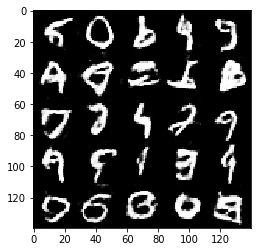

Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 0.5977... Generator Loss: 1.1277
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 0.7807
Epoch 2/2... Discriminator Loss: 0.6528... Generator Loss: 1.2040
Epoch 2/2... Discriminator Loss: 0.5916... Generator Loss: 1.4023
Epoch 2/2... Discriminator Loss: 0.9165... Generator Loss: 1.0120
Epoch 2/2... Discriminator Loss: 0.7488... Generator Loss: 1.3968
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 1.0579
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.4608
Epoch 2/2... Discriminator Loss: 0.9811... Generator Loss: 0.7178


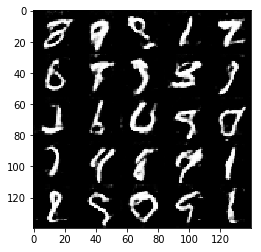

Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 0.5556
Epoch 2/2... Discriminator Loss: 1.9452... Generator Loss: 0.3103
Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 0.6259
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 0.7436
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.4592
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.2088
Epoch 2/2... Discriminator Loss: 0.7953... Generator Loss: 1.5208
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 0.8046
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 0.5289
Epoch 2/2... Discriminator Loss: 0.6423... Generator Loss: 1.4911


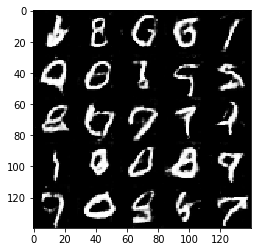

Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.3909
Epoch 2/2... Discriminator Loss: 0.8235... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 0.5408
Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 0.7159
Epoch 2/2... Discriminator Loss: 0.8275... Generator Loss: 0.9154
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.4334
Epoch 2/2... Discriminator Loss: 0.5992... Generator Loss: 1.2850
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 0.6045
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 3.3278


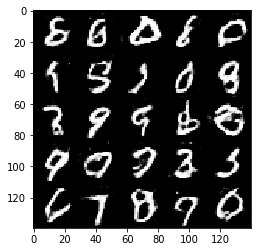

Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.5491
Epoch 2/2... Discriminator Loss: 0.4886... Generator Loss: 1.5080
Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 0.5303
Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 1.1547
Epoch 2/2... Discriminator Loss: 0.4984... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 0.7866... Generator Loss: 0.9083
Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 1.0484... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 3.0599
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 0.6242


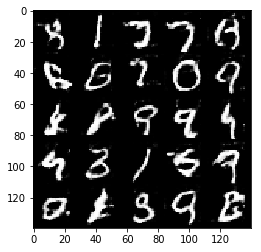

Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.3959
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 0.7163
Epoch 2/2... Discriminator Loss: 0.7705... Generator Loss: 0.9643
Epoch 2/2... Discriminator Loss: 0.5980... Generator Loss: 1.5001
Epoch 2/2... Discriminator Loss: 1.0273... Generator Loss: 2.1541
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 0.7766
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 0.9015
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 3.0995
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.0414


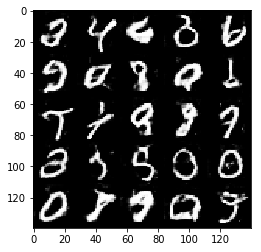

Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.4980
Epoch 2/2... Discriminator Loss: 0.6324... Generator Loss: 1.0199
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 0.5096... Generator Loss: 1.7185
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.0464
Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 0.6743
Epoch 2/2... Discriminator Loss: 0.6093... Generator Loss: 1.7757
Epoch 2/2... Discriminator Loss: 0.6159... Generator Loss: 1.2808
Epoch 2/2... Discriminator Loss: 0.7012... Generator Loss: 1.0365
Epoch 2/2... Discriminator Loss: 2.0328... Generator Loss: 0.2572


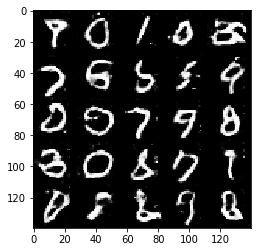

Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.6060
Epoch 2/2... Discriminator Loss: 0.7368... Generator Loss: 1.3165
Epoch 2/2... Discriminator Loss: 0.8777... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.5177
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 1.7075
Epoch 2/2... Discriminator Loss: 0.7422... Generator Loss: 0.9952
Epoch 2/2... Discriminator Loss: 0.6386... Generator Loss: 2.1833
Epoch 2/2... Discriminator Loss: 1.4921... Generator Loss: 0.3417
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 0.6628
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 0.5164


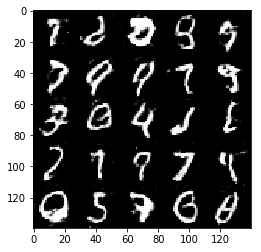

Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 0.9306
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.3045
Epoch 2/2... Discriminator Loss: 0.6937... Generator Loss: 1.2057


In [66]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6540... Generator Loss: 0.1169
Epoch 1/1... Discriminator Loss: 2.0320... Generator Loss: 0.2307
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.3206
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.4704


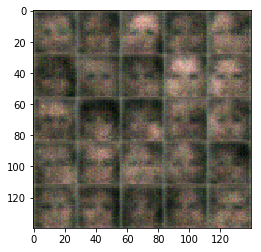

Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.6581
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.4984
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 2.5381
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 2.0137
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.4495


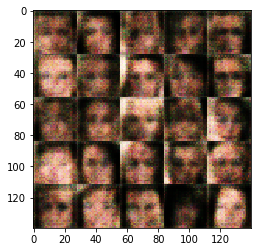

Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 2.0055... Generator Loss: 0.1824
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 0.6531... Generator Loss: 2.9330
Epoch 1/1... Discriminator Loss: 1.9530... Generator Loss: 4.3218
Epoch 1/1... Discriminator Loss: 0.2983... Generator Loss: 3.1894
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 0.3037... Generator Loss: 1.9582


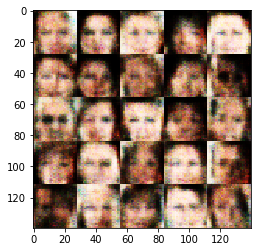

Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 1.9463
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 4.0126
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 4.9476
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 3.6480
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 3.2824
Epoch 1/1... Discriminator Loss: 0.3422... Generator Loss: 1.9289
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 1.1920


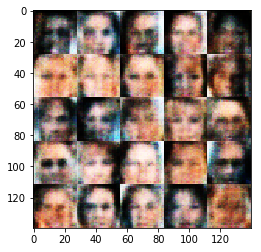

Epoch 1/1... Discriminator Loss: 2.2074... Generator Loss: 5.9587
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.3257
Epoch 1/1... Discriminator Loss: 1.7195... Generator Loss: 0.2319
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 1.4994
Epoch 1/1... Discriminator Loss: 1.9387... Generator Loss: 0.2240
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 2.1772
Epoch 1/1... Discriminator Loss: 0.7132... Generator Loss: 3.6490
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 1.8313
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 2.9902
Epoch 1/1... Discriminator Loss: 0.2947... Generator Loss: 2.5408


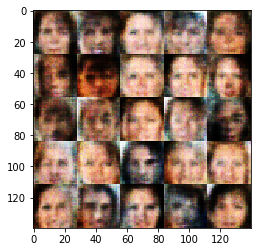

Epoch 1/1... Discriminator Loss: 0.1485... Generator Loss: 3.0038
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 2.8760
Epoch 1/1... Discriminator Loss: 0.3063... Generator Loss: 1.7898
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.4088
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 3.9421
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 4.0278


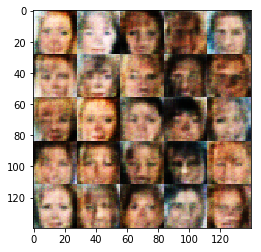

Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 2.0442... Generator Loss: 0.1840
Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 4.6456
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.7517
Epoch 1/1... Discriminator Loss: 0.1957... Generator Loss: 3.3960
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 5.4814
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.3138
Epoch 1/1... Discriminator Loss: 0.3636... Generator Loss: 4.0794


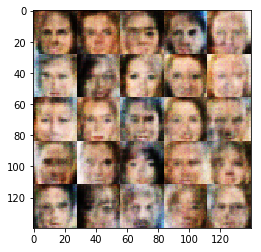

Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 3.5862
Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 2.6878
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 0.1924... Generator Loss: 2.2882
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.3370
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 2.2040... Generator Loss: 0.1489
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 2.6560
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 2.3994


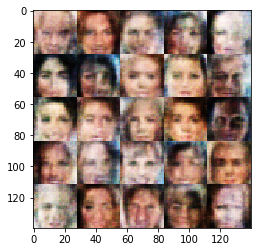

Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 3.3654
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 2.5012
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 2.7661
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 2.6593
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 2.3872
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.8788
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 2.3974
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 3.2033


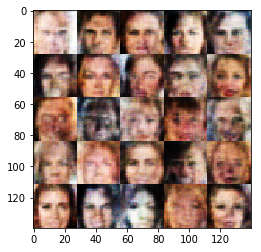

Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 1.6010
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 2.8505
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 2.4876
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 1.6186
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.3222
Epoch 1/1... Discriminator Loss: 2.3372... Generator Loss: 0.1302
Epoch 1/1... Discriminator Loss: 0.3116... Generator Loss: 2.6420
Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 2.4396
Epoch 1/1... Discriminator Loss: 0.3259... Generator Loss: 2.2956
Epoch 1/1... Discriminator Loss: 0.3631... Generator Loss: 3.4718


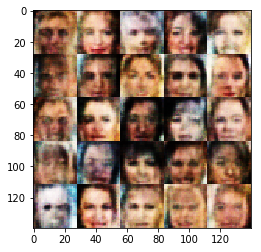

Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 3.6582
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.9093
Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 2.5640
Epoch 1/1... Discriminator Loss: 0.3777... Generator Loss: 2.4450
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 2.9392
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.3538
Epoch 1/1... Discriminator Loss: 2.4283... Generator Loss: 0.1407
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 4.9888
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.7503
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 3.1491


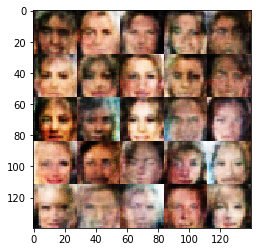

Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 4.0707
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 3.2214
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 2.2084
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.4348
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.3899
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 2.4922
Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 2.8268


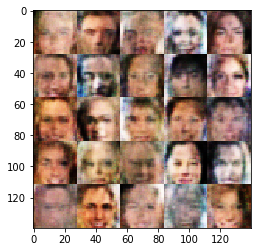

Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 3.2488
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.8761
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 2.2284
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 2.3736
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.5369
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.4326
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.6550


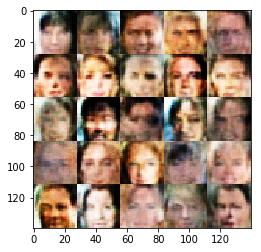

Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.3426
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 2.2540
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.7607
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 2.2121
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 2.1723
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 2.1394
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 2.2460
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 2.5199
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 1.4171


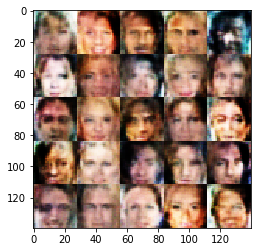

Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 3.4557
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 4.0339
Epoch 1/1... Discriminator Loss: 1.6749... Generator Loss: 0.2920
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 2.1500
Epoch 1/1... Discriminator Loss: 1.8537... Generator Loss: 0.2411
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.4566
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 2.1945
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 0.5685... Generator Loss: 2.2639


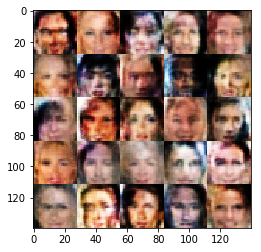

Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.7699
Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 2.9449
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 3.0312
Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 1.6305
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 3.6724
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 1.9024
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 2.0018
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.3353
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 2.9572


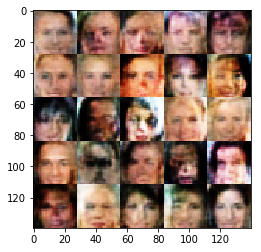

Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 3.3183
Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 2.6670
Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 3.0126
Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 2.1133
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.3993
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 2.4115
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.3781
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.4715


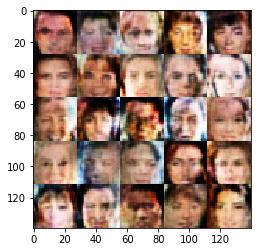

Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 0.3238... Generator Loss: 3.1501
Epoch 1/1... Discriminator Loss: 0.4799... Generator Loss: 1.7605
Epoch 1/1... Discriminator Loss: 0.2788... Generator Loss: 4.1584
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 2.5682
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 1.6838
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 3.5548


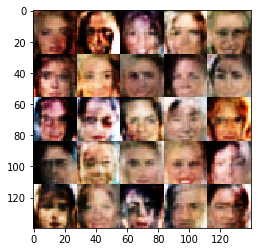

Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 2.1018
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 3.1541
Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 1.3617
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 4.7805
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.7231


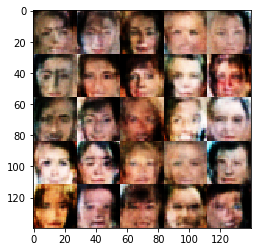

Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.3834
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 2.1194
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 1.6423
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 0.4576... Generator Loss: 1.6559
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.7514


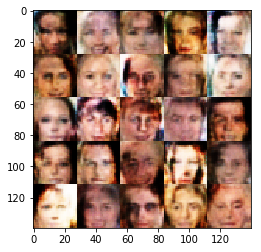

Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 5.8765
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 2.5188
Epoch 1/1... Discriminator Loss: 0.5621... Generator Loss: 2.5811
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 1.5049
Epoch 1/1... Discriminator Loss: 0.4435... Generator Loss: 1.8680
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 2.7690
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 6.2455


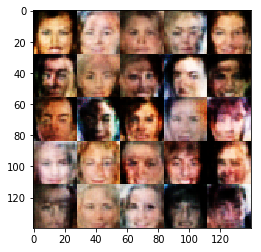

Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 3.4261
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 2.0782
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 3.9969
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 2.4264
Epoch 1/1... Discriminator Loss: 0.3075... Generator Loss: 3.1984
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 4.2977
Epoch 1/1... Discriminator Loss: 0.4983... Generator Loss: 2.2900


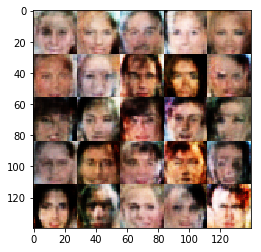

Epoch 1/1... Discriminator Loss: 0.3515... Generator Loss: 3.4168
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 3.1738
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 2.3817
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.9998
Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 2.9182
Epoch 1/1... Discriminator Loss: 0.3310... Generator Loss: 2.7548
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 2.1085
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 2.4471
Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 2.2617


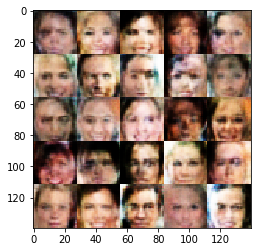

Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 1.7551
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 2.7159
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 2.6778
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 2.1498
Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 1.7925
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 3.6584
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 4.7936
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 3.0070


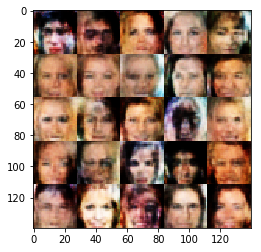

Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 2.6325
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 1.5155
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 2.4331
Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 4.3181
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 3.6481
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 2.6653


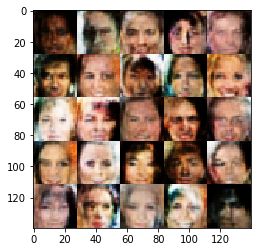

Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 3.1062
Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 3.7859
Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 2.8216
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 0.2551... Generator Loss: 3.2512
Epoch 1/1... Discriminator Loss: 0.3349... Generator Loss: 2.7574
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 2.1411
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 3.4557
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 3.0422


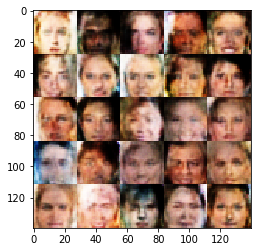

Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 2.3039
Epoch 1/1... Discriminator Loss: 0.2256... Generator Loss: 3.4834
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 3.5319
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 2.3997
Epoch 1/1... Discriminator Loss: 0.2524... Generator Loss: 3.7082
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 5.1162
Epoch 1/1... Discriminator Loss: 0.7278... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 0.2733... Generator Loss: 2.8963
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 3.8645
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 3.1336


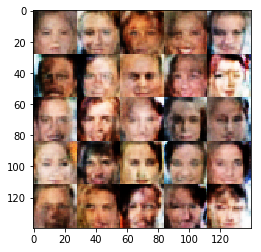

Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 1.2861
Epoch 1/1... Discriminator Loss: 0.2097... Generator Loss: 6.3840
Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 2.0938
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 2.0115
Epoch 1/1... Discriminator Loss: 0.3116... Generator Loss: 2.8236
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 2.4252
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.4665
Epoch 1/1... Discriminator Loss: 0.4737... Generator Loss: 2.7958
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 1.6542
Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 3.8418


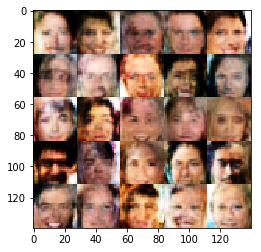

Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 3.4811
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 2.9268
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 2.1367
Epoch 1/1... Discriminator Loss: 0.3193... Generator Loss: 4.0055
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 3.6158
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 6.1824
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 1.4688


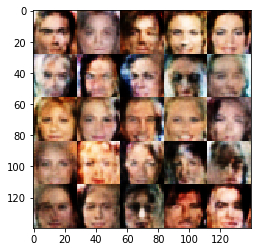

Epoch 1/1... Discriminator Loss: 0.2853... Generator Loss: 1.9492
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 2.3909
Epoch 1/1... Discriminator Loss: 0.2248... Generator Loss: 4.3361
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 1.4663
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 4.1537
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 2.5760
Epoch 1/1... Discriminator Loss: 0.2611... Generator Loss: 3.8277
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 1.9408


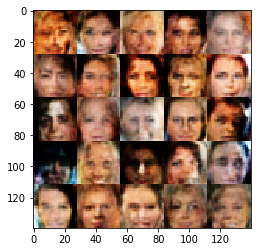

Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.5175
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 1.8394
Epoch 1/1... Discriminator Loss: 0.3015... Generator Loss: 2.5063
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 3.0152
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 2.7176
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 1.8373
Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 2.6018
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 2.5294


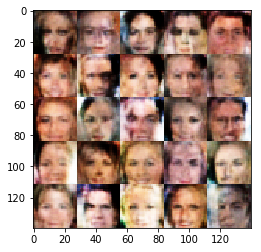

Epoch 1/1... Discriminator Loss: 0.3230... Generator Loss: 3.9010
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.8157
Epoch 1/1... Discriminator Loss: 0.1557... Generator Loss: 4.3831
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 1.6732
Epoch 1/1... Discriminator Loss: 0.2847... Generator Loss: 5.1984
Epoch 1/1... Discriminator Loss: 0.1894... Generator Loss: 4.6050
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 3.5176
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 4.4710
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 2.4362


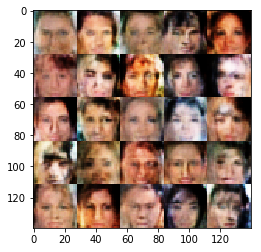

Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 2.3547
Epoch 1/1... Discriminator Loss: 0.1449... Generator Loss: 5.0840
Epoch 1/1... Discriminator Loss: 0.2289... Generator Loss: 5.2064
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 3.0779
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 2.0645
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 2.1685
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 0.2911... Generator Loss: 2.7134
Epoch 1/1... Discriminator Loss: 1.7347... Generator Loss: 1.7298


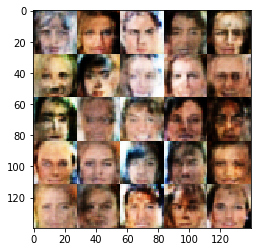

Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 2.6901
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 3.7306
Epoch 1/1... Discriminator Loss: 0.4496... Generator Loss: 4.1325
Epoch 1/1... Discriminator Loss: 0.2092... Generator Loss: 4.6008
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 2.2537
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 2.2546
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 5.1206
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 2.5341
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 0.9128


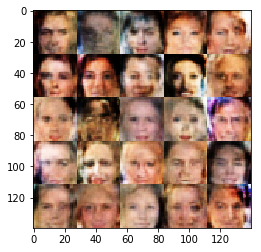

Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 2.2379
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 3.3051
Epoch 1/1... Discriminator Loss: 0.3803... Generator Loss: 2.5004
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.5606
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 4.5015
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 2.3078
Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 2.6595
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 4.8480


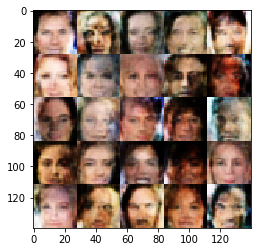

Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 4.6261
Epoch 1/1... Discriminator Loss: 0.1111... Generator Loss: 5.7260
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 4.4173
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 0.6870... Generator Loss: 1.4518
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 3.1461
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 0.4507... Generator Loss: 1.9240
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 2.4850
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 3.6599


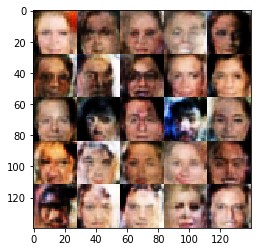

Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 3.5422
Epoch 1/1... Discriminator Loss: 0.2653... Generator Loss: 3.2770
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 2.1824
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.3552
Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 2.2707
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 5.3200
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 4.5809
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 2.6762
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.4583


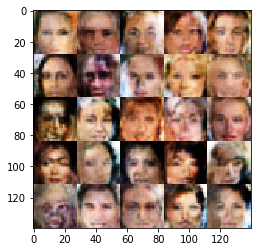

Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 3.5372
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 1.6564
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 1.9778
Epoch 1/1... Discriminator Loss: 0.3384... Generator Loss: 3.0800
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 3.0544
Epoch 1/1... Discriminator Loss: 0.1455... Generator Loss: 8.7195
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 3.2625
Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 2.9417
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 1.1559


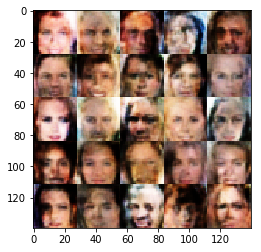

Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 1.5029
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 1.6323
Epoch 1/1... Discriminator Loss: 0.2471... Generator Loss: 2.4222
Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 2.0995
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 4.1133
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 3.1992
Epoch 1/1... Discriminator Loss: 0.2941... Generator Loss: 5.4174
Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 4.8139
Epoch 1/1... Discriminator Loss: 0.2897... Generator Loss: 3.4962
Epoch 1/1... Discriminator Loss: 0.2556... Generator Loss: 2.4558


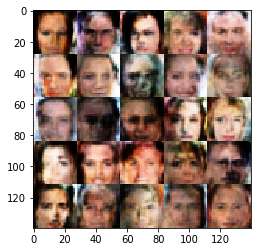

Epoch 1/1... Discriminator Loss: 0.2488... Generator Loss: 4.8310
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 3.0753
Epoch 1/1... Discriminator Loss: 0.1442... Generator Loss: 3.8412
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 3.3371
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 3.4991
Epoch 1/1... Discriminator Loss: 0.2053... Generator Loss: 3.8870
Epoch 1/1... Discriminator Loss: 0.3097... Generator Loss: 3.9755
Epoch 1/1... Discriminator Loss: 0.2256... Generator Loss: 2.6199
Epoch 1/1... Discriminator Loss: 0.2593... Generator Loss: 3.4927


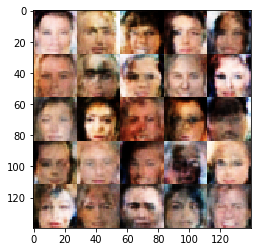

Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 4.5745
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.2116
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.0839
Epoch 1/1... Discriminator Loss: 0.3202... Generator Loss: 3.4270
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 2.2100
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 0.2593... Generator Loss: 4.5171
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.6718
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.3091


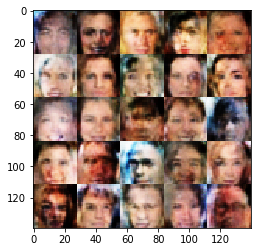

Epoch 1/1... Discriminator Loss: 0.2968... Generator Loss: 3.2501
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 3.3620
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 5.5853
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 2.7460
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 2.6618
Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 3.1943
Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 3.6020
Epoch 1/1... Discriminator Loss: 0.3607... Generator Loss: 2.7360
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 2.2972


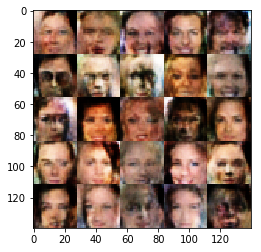

Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 3.0971
Epoch 1/1... Discriminator Loss: 0.2622... Generator Loss: 5.6395
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 3.1971
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 2.9629
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.1628
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 3.7188
Epoch 1/1... Discriminator Loss: 0.2710... Generator Loss: 4.7357
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 1.6646


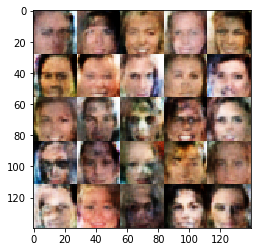

Epoch 1/1... Discriminator Loss: 0.3410... Generator Loss: 4.0002
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 4.3413
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 2.6695
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 1.5877
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 3.2360
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 2.1284
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 3.1997
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 2.7820


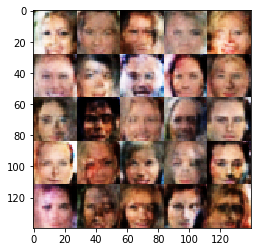

Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 1.6338
Epoch 1/1... Discriminator Loss: 0.2042... Generator Loss: 3.3596
Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 7.8719
Epoch 1/1... Discriminator Loss: 5.8961... Generator Loss: 4.3510
Epoch 1/1... Discriminator Loss: 2.0237... Generator Loss: 1.6676
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 2.6218
Epoch 1/1... Discriminator Loss: 0.3105... Generator Loss: 3.3982
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 1.5191
Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 2.5514
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 2.5653


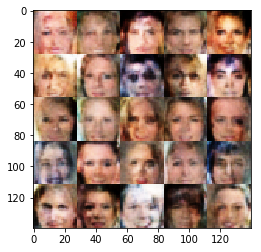

Epoch 1/1... Discriminator Loss: 0.3297... Generator Loss: 3.1498
Epoch 1/1... Discriminator Loss: 0.3279... Generator Loss: 3.2759
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 4.4960
Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 2.1133
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 3.9423... Generator Loss: 0.0592
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.5916
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 2.9383
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 7.1574
Epoch 1/1... Discriminator Loss: 0.2665... Generator Loss: 5.6851


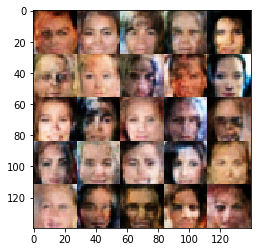

Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 3.4371
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 4.8489
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 3.0946
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 1.6667
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 2.2005
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 2.8353
Epoch 1/1... Discriminator Loss: 0.2803... Generator Loss: 2.5378
Epoch 1/1... Discriminator Loss: 0.3036... Generator Loss: 3.3486
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 3.0016


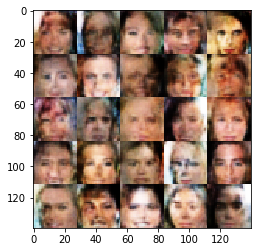

Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 2.3644
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 2.1273
Epoch 1/1... Discriminator Loss: 0.5773... Generator Loss: 3.5501
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 2.1802
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.8638
Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 3.1449
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 3.5895
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 3.6898
Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 2.9230
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 1.2404


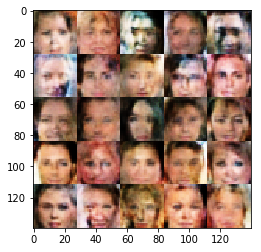

Epoch 1/1... Discriminator Loss: 0.4378... Generator Loss: 1.8502
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.7409
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 2.0983
Epoch 1/1... Discriminator Loss: 0.4921... Generator Loss: 1.9391
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 2.1900
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 1.4450
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 2.4590
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 2.3771
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 3.4101
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 1.6332


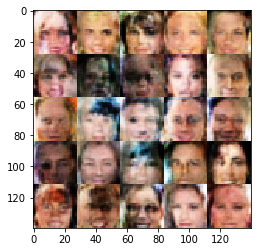

Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 4.9856
Epoch 1/1... Discriminator Loss: 0.6783... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 1.9581... Generator Loss: 0.2031
Epoch 1/1... Discriminator Loss: 0.6532... Generator Loss: 1.8917
Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 3.1891
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 1.8911
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 2.3386
Epoch 1/1... Discriminator Loss: 0.3007... Generator Loss: 4.3253
Epoch 1/1... Discriminator Loss: 0.2966... Generator Loss: 3.7591


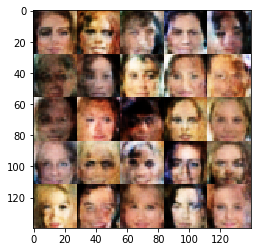

Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 2.9180
Epoch 1/1... Discriminator Loss: 0.2672... Generator Loss: 3.5772
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 1.8114
Epoch 1/1... Discriminator Loss: 0.2133... Generator Loss: 6.0867
Epoch 1/1... Discriminator Loss: 0.3195... Generator Loss: 3.3002
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 4.8096
Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 2.4038
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 2.5228
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.5691
Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 1.3763


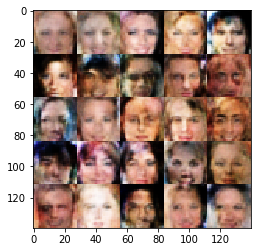

Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 2.4461
Epoch 1/1... Discriminator Loss: 0.3184... Generator Loss: 3.0040
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 2.7750
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 3.8854
Epoch 1/1... Discriminator Loss: 1.8957... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 1.7952
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 4.2241
Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 2.9310
Epoch 1/1... Discriminator Loss: 0.3301... Generator Loss: 2.8660


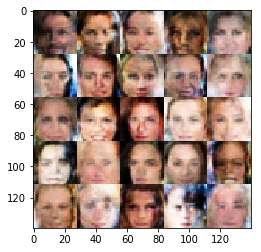

Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 2.1311
Epoch 1/1... Discriminator Loss: 0.2134... Generator Loss: 5.0458
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 3.9159
Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 1.6969... Generator Loss: 0.3007
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 3.7357
Epoch 1/1... Discriminator Loss: 0.3154... Generator Loss: 4.8437
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 1.6937
Epoch 1/1... Discriminator Loss: 0.3095... Generator Loss: 3.5273


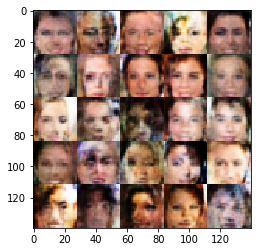

Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 2.6353
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 3.6358
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 3.1870
Epoch 1/1... Discriminator Loss: 0.2505... Generator Loss: 3.5513
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 2.1614
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.6240
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 4.5411
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 4.9567
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 1.1621


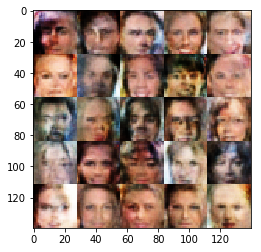

Epoch 1/1... Discriminator Loss: 3.2644... Generator Loss: 0.0703
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 2.3057
Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 3.1046
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 2.0458
Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 1.7907
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 2.4688
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.8000
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 2.1944


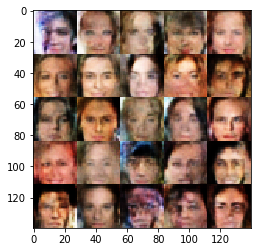

Epoch 1/1... Discriminator Loss: 0.2950... Generator Loss: 3.3944
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 2.0909
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 3.1082
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 2.6198
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 1.5996
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 3.1489
Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 3.1301
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 2.6341
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.8450
Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 3.3696


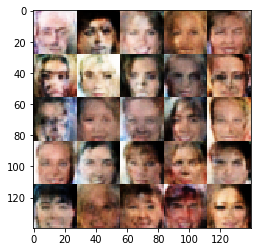

Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 2.0408
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 2.9932
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 2.1141
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 4.7371
Epoch 1/1... Discriminator Loss: 2.8110... Generator Loss: 0.1265
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 2.7373
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 1.2973
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.4954


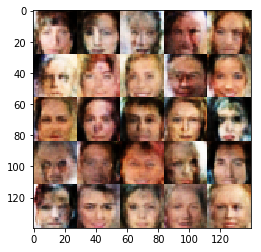

Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 1.7756
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 1.9095
Epoch 1/1... Discriminator Loss: 0.2793... Generator Loss: 3.6713
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 2.1713
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 3.4970
Epoch 1/1... Discriminator Loss: 0.2944... Generator Loss: 3.0272
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 2.2414
Epoch 1/1... Discriminator Loss: 0.3513... Generator Loss: 3.5681
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 3.3157


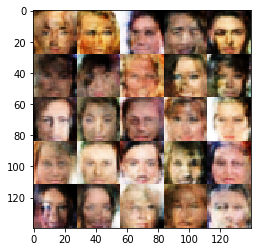

Epoch 1/1... Discriminator Loss: 0.3607... Generator Loss: 2.4156
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 2.2198
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.8100
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 1.9632
Epoch 1/1... Discriminator Loss: 2.7315... Generator Loss: 0.2378
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 3.8825
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 6.0235
Epoch 1/1... Discriminator Loss: 1.6852... Generator Loss: 2.0489


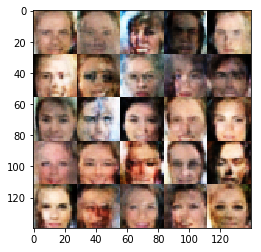

Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 1.2973
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 2.0595
Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 2.1392
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 2.9776
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 0.2838... Generator Loss: 2.5192


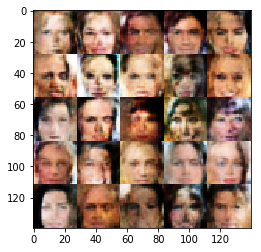

Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 2.1639
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.3687
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 3.1122
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 3.0184
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 2.3667


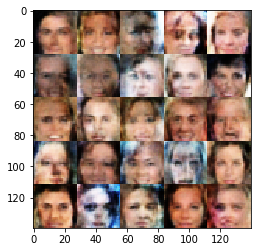

Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 2.2602
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 5.0558
Epoch 1/1... Discriminator Loss: 0.5853... Generator Loss: 2.4149
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 1.8569
Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 4.4668
Epoch 1/1... Discriminator Loss: 0.3266... Generator Loss: 2.7513
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.4405
Epoch 1/1... Discriminator Loss: 0.4376... Generator Loss: 2.5107


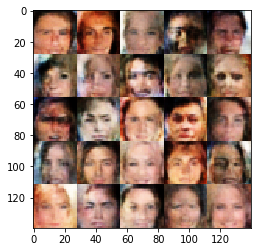

Epoch 1/1... Discriminator Loss: 0.3417... Generator Loss: 4.1555
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 1.5869
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 3.0897
Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 2.2285
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 2.6503
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 3.2442
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 2.1792
Epoch 1/1... Discriminator Loss: 2.0051... Generator Loss: 2.2944
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 1.4156


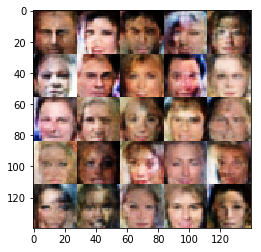

Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.5327
Epoch 1/1... Discriminator Loss: 0.3402... Generator Loss: 2.9188
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 4.0916


In [70]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.